In [2]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [15]:
actions = [
    'come',
    'away',
    'spin',
    'hello'
]

data = np.concatenate([
    np.load('/home/seojin/Documents/gesture-recognition/dataset/seq_away_1725372496.npy'),
    np.load('/home/seojin/Documents/gesture-recognition/dataset/seq_come_1725372496.npy'),
    np.load('/home/seojin/Documents/gesture-recognition/dataset/seq_hello_1725372496.npy'),
    np.load('/home/seojin/Documents/gesture-recognition/dataset/seq_spin_1725372496.npy')
], axis=0)

data.shape

(3484, 30, 100)

In [16]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(3484, 30, 99)
(3484,)


In [17]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(3484, 4)

In [18]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(3135, 30, 99) (3135, 4)
(349, 30, 99) (349, 4)


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:4]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                41984     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 4)                 132       
                                                                 
Total params: 44196 (172.64 KB)
Trainable params: 44196 (172.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/200
98/98 [==============================] - ETA: 0s - loss: 19.3913 - acc: 0.6124
Epoch 1: val_acc improved from -inf to 0.83668, saving model to models/model.h5
98/98 [==============================] - 11s 53ms/step - loss: 19.3913 - acc: 0.6124 - val_loss: 1.4860 - val_acc: 0.8367 - lr: 0.0010
Epoch 2/200


/home/seojin/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


98/98 [==============================] - ETA: 0s - loss: 0.5117 - acc: 0.8973
Epoch 2: val_acc improved from 0.83668 to 0.90831, saving model to models/model.h5
98/98 [==============================] - 5s 49ms/step - loss: 0.5117 - acc: 0.8973 - val_loss: 0.4823 - val_acc: 0.9083 - lr: 0.0010
Epoch 3/200
98/98 [==============================] - ETA: 0s - loss: 0.1941 - acc: 0.9499
Epoch 3: val_acc improved from 0.90831 to 0.95989, saving model to models/model.h5
98/98 [==============================] - 4s 42ms/step - loss: 0.1941 - acc: 0.9499 - val_loss: 0.0847 - val_acc: 0.9599 - lr: 0.0010
Epoch 4/200
98/98 [==============================] - ETA: 0s - loss: 0.3741 - acc: 0.9238
Epoch 4: val_acc did not improve from 0.95989
98/98 [==============================] - 5s 46ms/step - loss: 0.3741 - acc: 0.9238 - val_loss: 0.4496 - val_acc: 0.8968 - lr: 0.0010
Epoch 5/200
98/98 [==============================] - ETA: 0s - loss: 0.2712 - acc: 0.9518
Epoch 5: val_acc improved from 0.95989 to

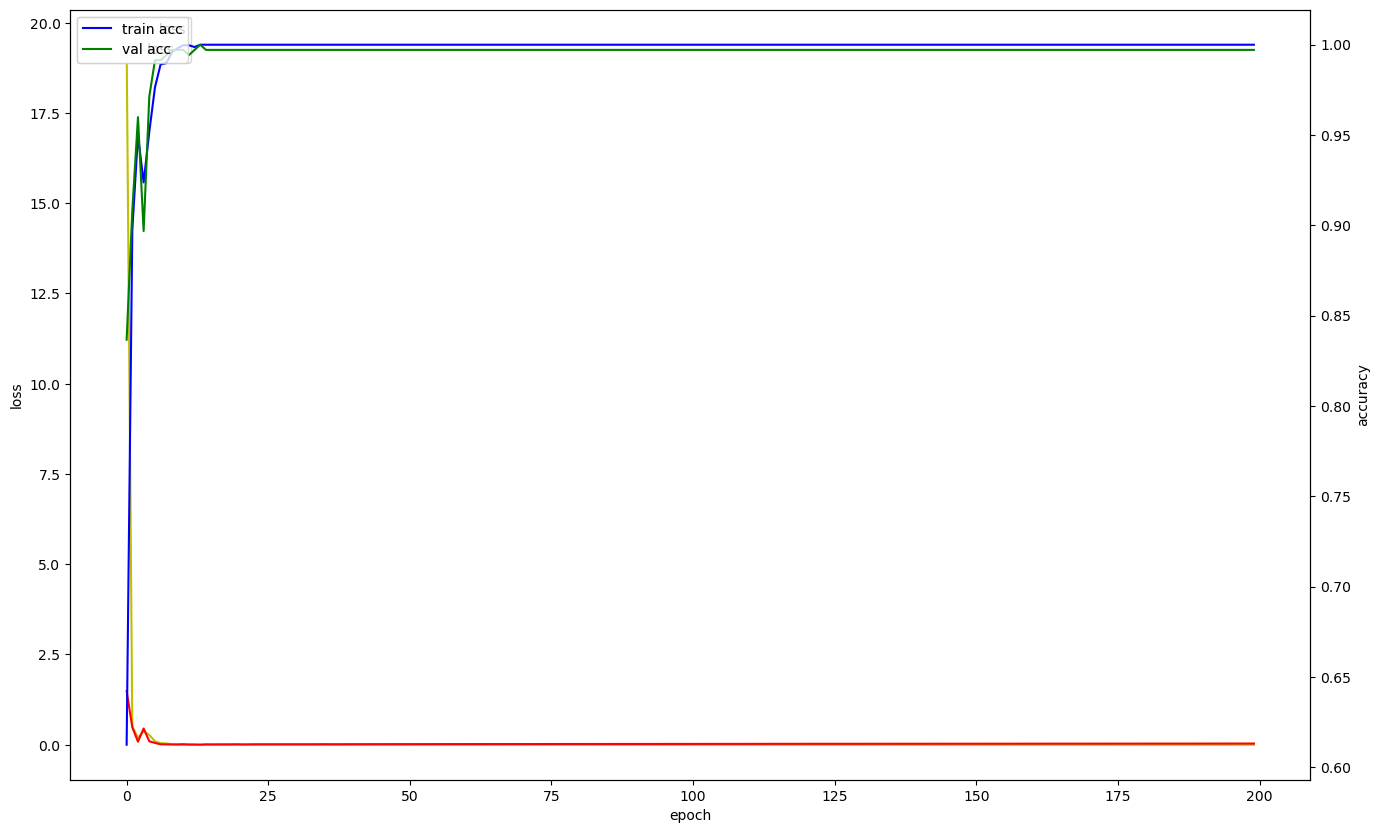

In [22]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [23]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/model.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

11/11 [==============================] - 0s 7ms/step


array([[[263,   0],
        [  0,  86]],

       [[268,   0],
        [  0,  81]],

       [[247,   0],
        [  0, 102]],

       [[269,   0],
        [  0,  80]]])